/tmp/ipykernel_1742429/2215924968.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(
100%|██████████| 1000/1000 [05:33<00:00,  3.00it/s]


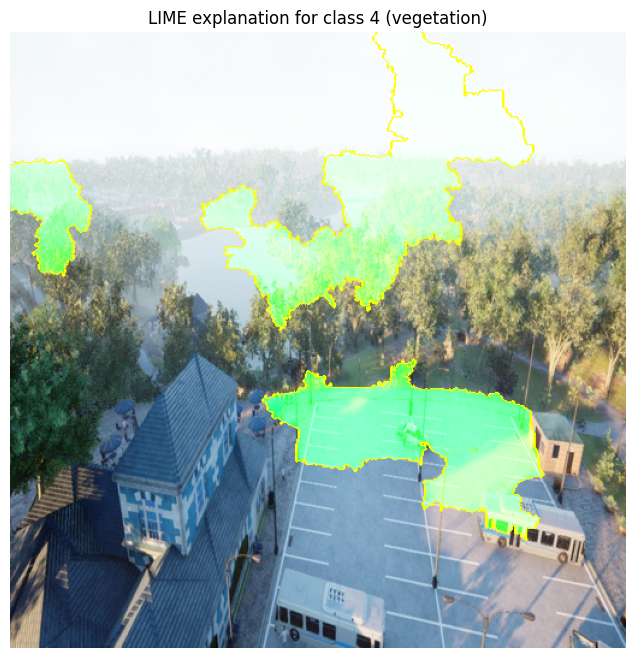

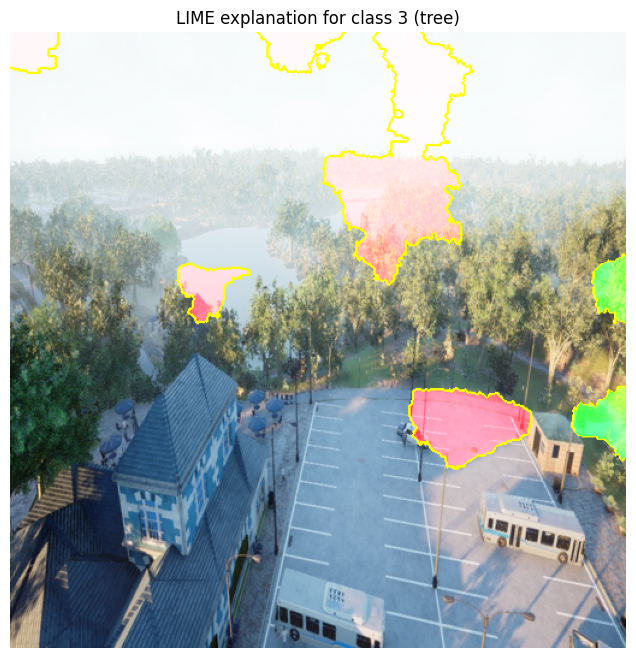

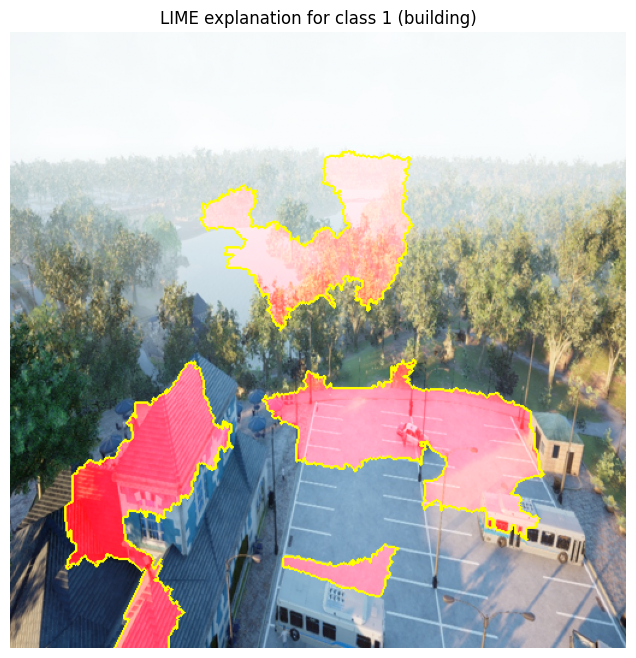

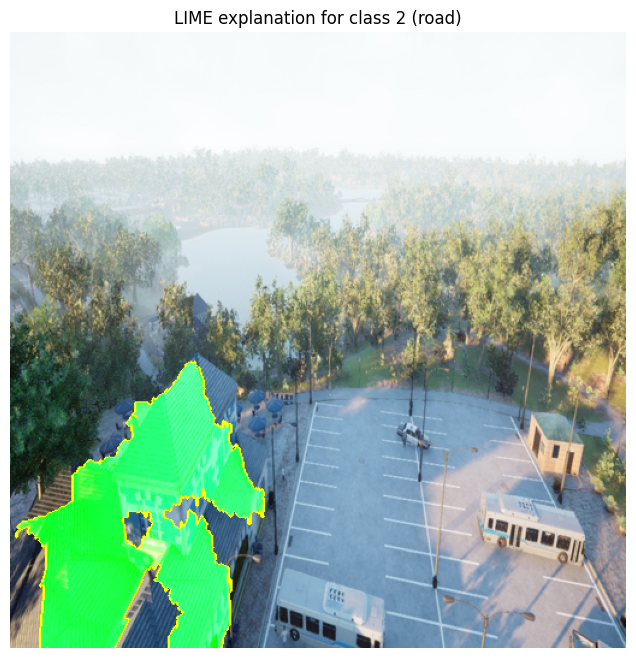

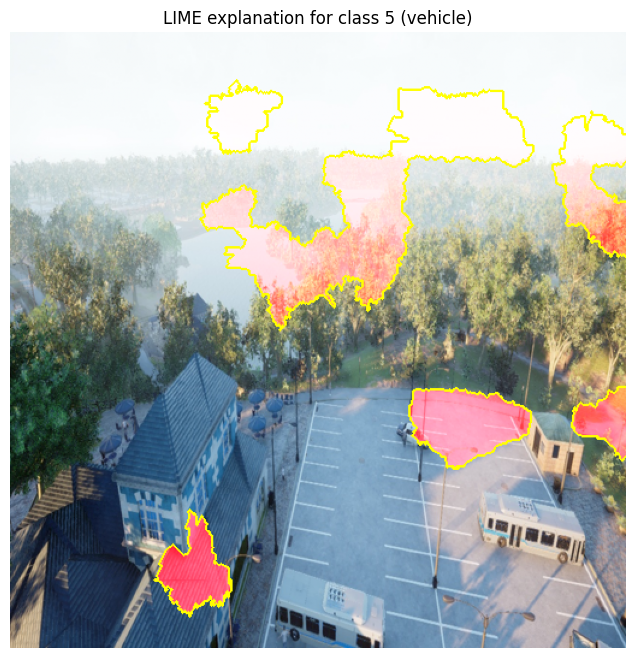

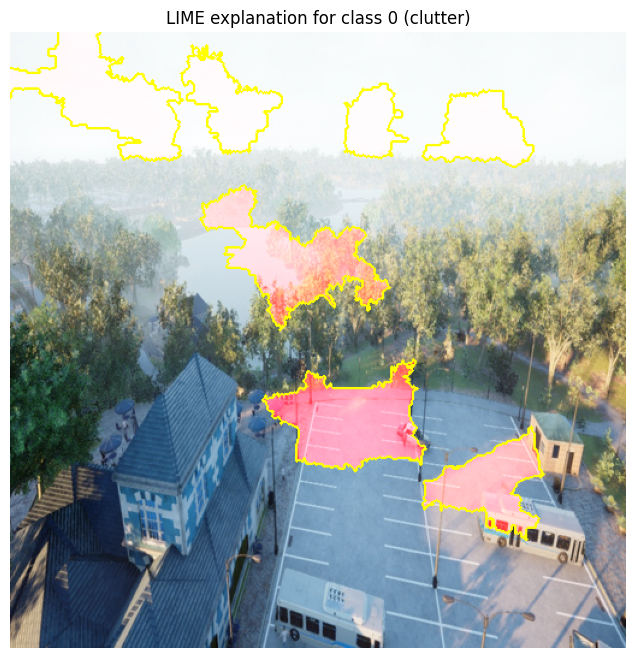

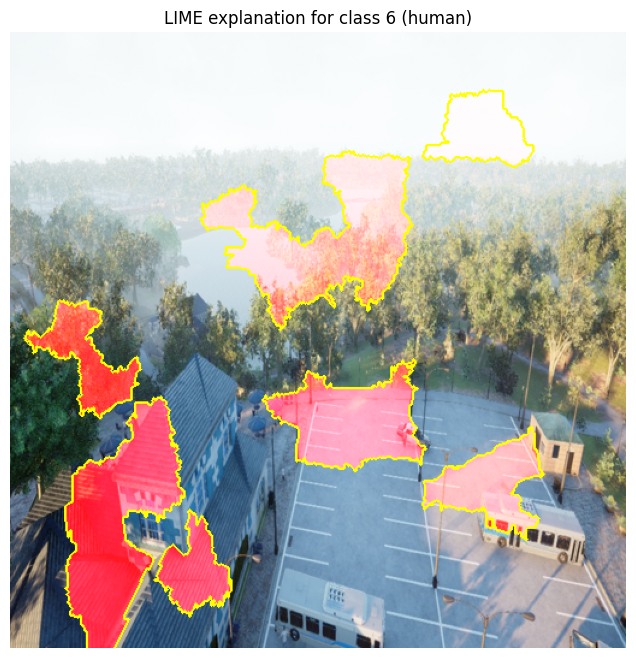

In [2]:
import torch
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# 1. Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 7

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=num_classes
)

checkpoint = torch.load(
    "/home/pnaray2s/workspace/Learnings/Xai/sss/my_checkpoints/H1_Experiments/data_processed_citypark_25m_H1_Experiments_citypark_synthetic_25m_pretrained_unet_unet_miou0.5013_epoch60_best.pth",
    map_location=device
)
class_names = checkpoint.get("class_names", None)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 2. Preprocess image
image_path = "/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/citypark/data_processed_citypark_25m/test/Images/scene_2014.jpeg"
pil_image = Image.open(image_path).convert("RGB").resize((512,512))
original_image = np.array(pil_image)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def segmentation_predict(images_np):
    images_torch = torch.tensor(images_np.transpose(0,3,1,2)).float()
    # normalize
    for t in images_torch:
        t[0] = (t[0]-0.485)/0.229
        t[1] = (t[1]-0.456)/0.224
        t[2] = (t[2]-0.406)/0.225
    images_torch = images_torch.to(device)
    with torch.no_grad():
        outputs = model(images_torch)
        probs = torch.softmax(outputs, dim=1)
        # pool to global class probabilities
        pooled = probs.mean(dim=(2,3)).cpu().numpy()  # shape [n_samples, 7]
    return pooled

# 3. LIME explainer
explainer = lime_image.LimeImageExplainer()

# 4. Explain
explanation = explainer.explain_instance(
    original_image,
    segmentation_predict,
    top_labels=7,
    hide_color=0.5,
    num_samples=1000
)

# 5. Visualize per class
for class_idx in explanation.top_labels:
    temp, mask = explanation.get_image_and_mask(
        class_idx,
        positive_only=False,
        num_features=10,
        hide_rest=False
    )
    plt.figure(figsize=(8,8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME explanation for class {class_idx} ({class_names[class_idx]})")
    plt.axis('off')
    plt.show()



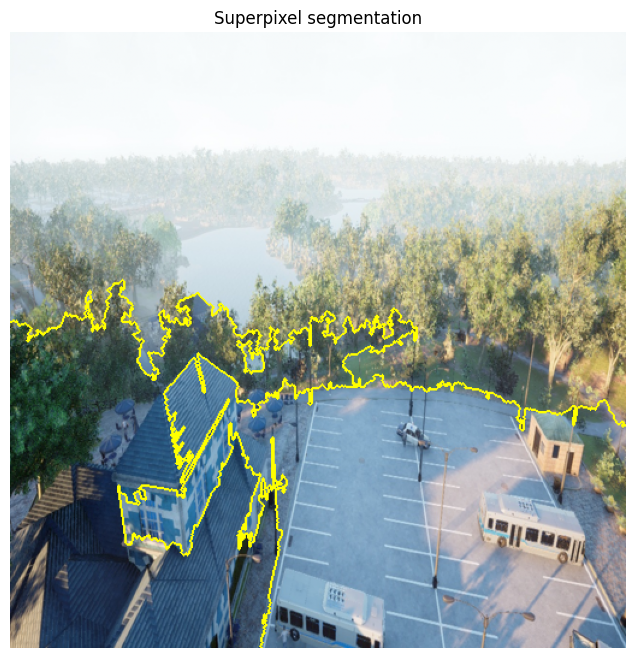

In [8]:
from skimage.segmentation import slic, mark_boundaries

image = np.array(Image.open("/home/pnaray2s/workspace/Learnings/Xai/sss/datasets/final/citypark/data_processed_citypark_25m/test/Images/scene_2014.jpeg").resize((512,512)))

# create ~50 superpixels
segments = slic(image, n_segments=10, compactness=10)

plt.figure(figsize=(8,8))
plt.imshow(mark_boundaries(image, segments))
plt.title("Superpixel segmentation")
plt.axis('off')
plt.show()
